

### Learning Objectives

After this lesson you will be able to:
- Use ARIMA and its variants to forecast time series values


#### Prior knoweldge required
- Python, pandas, and machine learning basics
- Time series basics
- Understand autoregression 
---

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Stationarity

The criteria for classifying a series as stationary are that the **mean** and **variance** are not a function of time. 

Stationarity in mean and variance: 
![](assets/stationary_mean_var.png)
From [this comprehensive article](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322). 

**A stationary time series has no predictable pattern in the long-term.**



#### How can we test for stationarity? 

One way is by visualizing the data. Is the data below stationary?

![](assets/dow-jones.png)

Stationarity Quiz: 
https://otexts.com/fpp3/stationarity.html

### Testing for stationarity
If this visual check didn't show non-stationarity so clearly, we could use the **Augmented Dickey-Fuller test**: A statistical test of stationarity. 

$$
\begin{eqnarray}
&H_0:& \text{time series is NOT stationary} \\
&H_A:& \text{time series is stationary}
\end{eqnarray}
$$

`adfuller` is the method in the statsmodels library.

---
## Making time series more stationary

To manually make a time series more stationary by removing the trend, you can use **detrending** or **differencing**.

## Example: Detrending

To detrend:
1. Make a line of best fit (Linear Regression)
2. Subtract the values predicted by Linear Regression from the actual values

### Read in drone racing data 

In [2]:
drones = pd.read_csv('data/gt_drone_racing.csv', header=1, )
drones.columns = ['week','drone_racing_interest']
drones.head()

,week,drone_racing_interest
0,2014-11-09,2
1,2014-11-16,2
2,2014-11-23,4
3,2014-11-30,6
4,2014-12-07,7


In [3]:
drones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   week                   108 non-null    object
 1   drone_racing_interest  108 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


#### Do the datetime and index conversion and sort 

In [4]:
drones['week'] = pd.to_datetime(drones['week'])

In [5]:
drones.set_index('week', inplace=True)
drones.sort_index(inplace=True)

In [6]:
drones.head()

,drone_racing_interest
week,
2014-11-09,2
2014-11-16,2
2014-11-23,4
2014-11-30,6
2014-12-07,7


#### Make a best-fit line

In [7]:
# Make the data numeric
X = pd.to_numeric(drones.index)
X = X.to_numpy().reshape(-1, 1)
y = drones['drone_racing_interest']

In [8]:
X[:10]

array([[1415491200000000000],
       [1416096000000000000],
       [1416700800000000000],
       [1417305600000000000],
       [1417910400000000000],
       [1418515200000000000],
       [1419120000000000000],
       [1419724800000000000],
       [1420329600000000000],
       [1420934400000000000]])

In [9]:
y.head()

week
2014-11-09    2
2014-11-16    2
2014-11-23    4
2014-11-30    6
2014-12-07    7
Name: drone_racing_interest, dtype: int64

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [12]:
preds = lr.predict(X)

#### Plot it

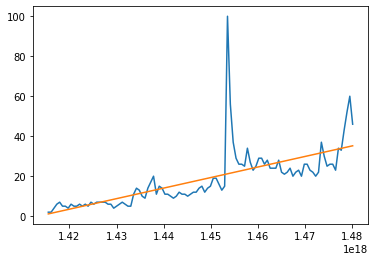

In [13]:
plt.plot(X, y)
plt.plot(X, preds);

In [14]:
detrended = y - preds

In [15]:
detrended.head()

week
2014-11-09    0.868502
2014-11-16    0.550087
2014-11-23    2.231673
2014-11-30    3.913258
2014-12-07    4.594844
Name: drone_racing_interest, dtype: float64

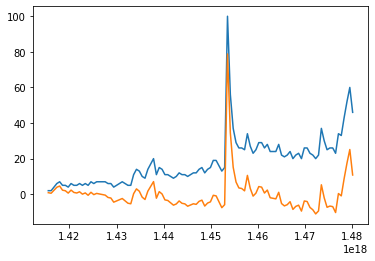

In [16]:
plt.plot(X, y)
plt.plot(X, detrended);

Congrats! You just detrended! 🎉

---
### Differencing

Another method to make time series data more stationarity is **differencing**. 

The differenced series is the change between consecutive observations. So subtract the value at time `t-1` from the value at `t`. 

Earlier you saw how to use the pandas `.diff()` method to find the difference between one time period and the time period before. 

#### Use `diff()` to manually difference the data.

In [17]:
drones['difference'] = drones['drone_racing_interest'].diff()
drones.head()

,drone_racing_interest,difference
week,,
2014-11-09,2,NaN
2014-11-16,2,0.0
2014-11-23,4,2.0
2014-11-30,6,2.0
2014-12-07,7,1.0


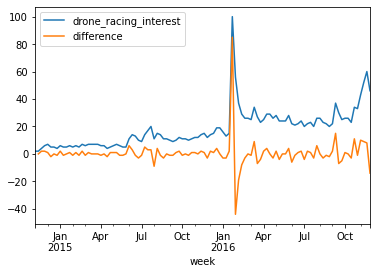

In [18]:
drones.plot();

#### How does the result of detrending compare to the result of differencing?

2nd order differencing is modeling the change in changes.🤔

"In practice, it is almost never necessary to go beyond second-order differences." - [Hyndman](https://otexts.com/fpp3/stationarity.html)

---
## AR

#### You've seen AR (autoregression). How would you describe it?

Using past values to predict future values (of y) using linear regression.

---
# ARIMA
Now let's do AutoRegression but take into account the trend with ARIMA: Auto-Regressive Integrated Moving Average.🚀

The *Moving Average* here really means fitting the errors - kind of like gradient boosting models fit the errors of earlier models with subsequent models. 

An $ARIMA(p, d, q)$ model is specified by
- how many lags $p$ we regress $Y_t^{(d)}$ on.
- how many differences $d$ we need to calculate in order to best achieve stationarity.
- how many errors $q$ we regress $Y_t^{(d)}$ on. 



Three hyperparameters when fitting an ARIMA model:
1. Determine a value of $d$ using the Augmented Dickey-Fuller test or KPSS test.
2. Determine values of $p$ and $q$ through grid searching.

We'll use the sales data we were using with exponential smoothing models. 

We know there is seasonality here. Let's skip to the next extension: SARIMA.


---
# SARIMA

SARIMA adds seasonality to ARIMA (and you get to choose 4 more parameters). 😀

There are a total of 7 parameters to choose `(p, d, q)` `(P, D, Q)` and `m`. 

- `p` is for the autoregressive component (lags)
- `d` stands for differencing
- `q` is essentially what controls the the moving average window size.

The next three capitalized arguments (`P`, `D`, and `Q`) are for the seasonal components of the equation.

- `m` is for the number of observations per seasonal cylce. 

### For weekly sales data with annual holiday seasonality, `m` would be 52 (for 52 weeks). 

If you had montly data with annual holiday seasonality, what would `m` be?

More in-depth explanation of all the parameters [here](https://alkaline-ml.com/pmdarima/tips_and_tricks.html#understand-p-d-and-q).


## SARIMA with auto-arima 

There are a bunch of ways to find parameter values for SARIMA. You can use autocorrelation plots and partial correlation plots and individual statistical tests to try to figure out parameters. 

Let's use a package that makes GridSearching easier. [pmdarima](https://pypi.org/project/pmdarima/) wraps statsmodels SARIMA under the hood and is designed to have a more sklearn-like API.

#### Using pandas, read in the sales data we saved previously 

In [19]:
train = pd.read_pickle('data/train.pkl')
train.head()

,sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


In [20]:
test = pd.read_pickle('data/test.pkl')
test.head()

,sales
Date,
2012-02-03,1636339.65
2012-02-10,1802477.43
2012-02-17,1819870.00
2012-02-24,1539387.83
2012-03-02,1688420.76


In [21]:
df_predictions = pd.read_pickle('data/df_predictions.pkl')
df_predictions.head()

,sales,last,simple_mean,seasonal,ses,hw
Date,,,,,,
2012-02-03,1636339.65,1319325.59,1.537735e+06,1606629.58,1.398212e+06,1.666958e+06
2012-02-10,1802477.43,1319325.59,1.537735e+06,1649614.93,1.398212e+06,1.710615e+06
2012-02-17,1819870.00,1319325.59,1.537735e+06,1686842.78,1.398212e+06,1.747635e+06
2012-02-24,1539387.83,1319325.59,1.537735e+06,1456800.28,1.398212e+06,1.510648e+06
2012-03-02,1688420.76,1319325.59,1.537735e+06,1636263.41,1.398212e+06,1.696626e+06


In [23]:
#!pip install pmdarima # uncomment if need to install - may fail with cython issue, if so use colab

In [24]:
import pmdarima as pmd
from pmdarima.utils import tsdisplay

Make some plots.

/opt/anaconda3/lib/python3.8/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


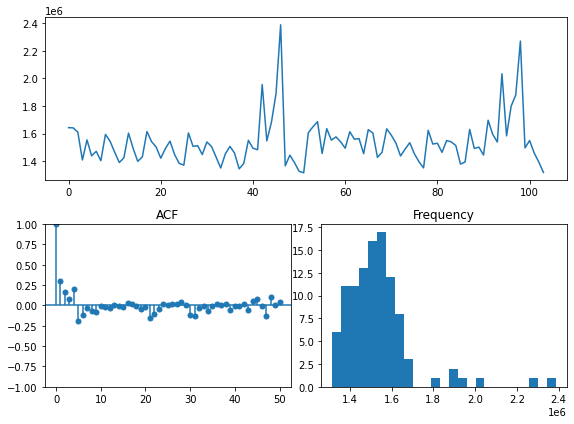

In [25]:
tsdisplay(train)

Let's instantiate a model. 

`m=52` for the number of observations per seasonal cycle

In [26]:
model = pmd.arima.ARIMA(order=(4,0,2), seasonal_order=(1,0,0,52))
model.fit(train['sales'])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(4, 0, 2), seasonal_order=(1, 0, 0, 52))

In [ ]:
# model = pmd.auto_arima(train['sales'], m=52, trace=True)

By default, pmdarima tries 4 common possible models. Then models similar to the best model found are considered. Model performance is determined by the lowest AIC (or BIC).

Or you could specifying parameters by hand.

In [27]:
from statsmodels.tsa.stattools import adfuller

output = adfuller(train['sales'])
output

(-4.505791778790324,
 0.00019195538071253002,
 4,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 2417.8420021372362)

In [28]:
pd.Series(output[:2], index=['test_stat', 'p-value'])

test_stat   -4.505792
p-value      0.000192
dtype: float64

In [29]:
from pmdarima.arima.utils import ndiffs

In [30]:
ndiffs(train['sales'], test='adf')

0

In [31]:
model = pmd.auto_arima(
    train['sales'], 
    start_p=1, 
    start_q=1,
    max_p=2,                 # Hyndman says p almost never > 2
    max_q=2,
    d=0,                     # from ndiffs testing
    start_P=1, 
    start_Q=1,
    max_P=2,                
    max_Q=2,
    seasonal=True, 
    m=52,
    error_action='ignore',   # don't want to know if an order does not work
    suppress_warnings=True,  # don't want convergence warnings
)

# # autoarima uses KPSS test instead of ADF for stationarity, by defualt

In [32]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  104
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -1375.542
Date:                             Thu, 01 Dec 2022   AIC                           2765.085
Time:                                     10:38:16   BIC                           2783.595
Sample:                                          0   HQIC                          2772.584
                                             - 104                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.037e+06   6.48e-07    1.6e+12      0.000    1.04e+06    1.04e+06
ar.L1         -0.6449      0.400     -1.612      0.107      -1.429       0.139
ar.L2         -0.0939      0.529     -0.178      0.859      -1.131       0.943
ma.L1          1.0512      0.403      2.611      0.009       0.262       1.840
ma.L2          0.5246      0.303      1.732      0.083      -0.069       1.118
ar.S.L52       0.6114      0.061     10.002      0.000       0.492       0.731
sigma2       2.52e+10   1.63e-11   1.55e+21      0.000    2.52e+10    2.52e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               151.84
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                             1.15
Prob(H) (two-sided):                  0.22   Kurtosis:                         8.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.92e+36. Standard errors may be unstable.
"""

The Model displays the final parameters. Now we can use the model object to predict the "future" values.

#### Read in the sales predictions we made earlier and add the sarima predictions

In [33]:
df_predictions.head()

,sales,last,simple_mean,seasonal,ses,hw
Date,,,,,,
2012-02-03,1636339.65,1319325.59,1.537735e+06,1606629.58,1.398212e+06,1.666958e+06
2012-02-10,1802477.43,1319325.59,1.537735e+06,1649614.93,1.398212e+06,1.710615e+06
2012-02-17,1819870.00,1319325.59,1.537735e+06,1686842.78,1.398212e+06,1.747635e+06
2012-02-24,1539387.83,1319325.59,1.537735e+06,1456800.28,1.398212e+06,1.510648e+06
2012-03-02,1688420.76,1319325.59,1.537735e+06,1636263.41,1.398212e+06,1.696626e+06


In [34]:
preds = model.predict(test.shape[0])
preds

array([1548974.29866483, 1596704.0715092 , 1636147.01261059,
       1482727.15038844, 1599120.44807074, 1545228.71217531,
       1561047.80998071, 1538616.78539367, 1510724.24382327,
       1583490.58860669, 1550294.91241656, 1553290.13084679,
       1486210.8726973 , 1592773.34264577, 1577724.976288  ,
       1469778.66728691, 1492906.90268937, 1596251.4075399 ,
       1568047.89677515, 1533300.36683351, 1476266.8706026 ,
       1506657.89282722, 1534972.39517631, 1486226.32992053,
       1450647.51679915, 1423314.00616899, 1589712.81336242,
       1529040.33543913, 1532472.89675707, 1492079.48317096,
       1544375.34347777, 1538409.39474479, 1522383.92363733,
       1440310.99107181, 1449201.58128092, 1593751.78970557,
       1509707.41824125, 1515232.47402143, 1480191.35524466])

In [35]:
df_predictions['sarima_auto'] = preds
df_predictions.head(3)

,sales,last,simple_mean,seasonal,ses,hw,sarima_auto
Date,,,,,,,
2012-02-03,1636339.65,1319325.59,1.537735e+06,1606629.58,1.398212e+06,1.666958e+06,1.548974e+06
2012-02-10,1802477.43,1319325.59,1.537735e+06,1649614.93,1.398212e+06,1.710615e+06,1.596704e+06
2012-02-17,1819870.00,1319325.59,1.537735e+06,1686842.78,1.398212e+06,1.747635e+06,1.636147e+06


#### Plot

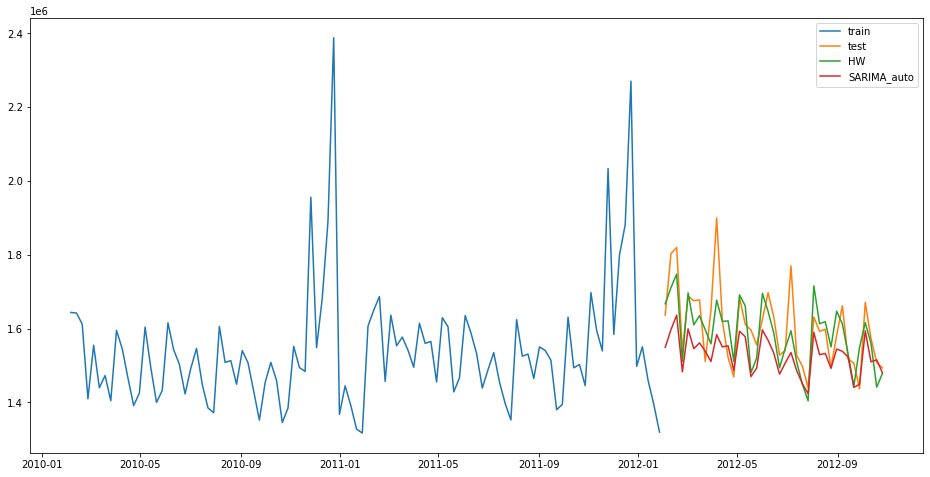

In [36]:
plt.figure(figsize=(16,8))
plt.plot(train['sales'], label='train')
plt.plot(test['sales'], label='test')
plt.plot(df_predictions['hw'], label='HW')
plt.plot(df_predictions['sarima_auto'], label='SARIMA_auto')
plt.legend();

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
mean_squared_error(test['sales'], preds, squared=False)

102845.61476066131

#### How did that model perform?

Not bad, but worse than HW

Could try other values for SARIMA. The search wasn't exhaustive.

---
# SARIMAX

SARIMAX extends SARIMA. The X in [SARIMAX](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) stands for eXogenous variables. Exogenous means "external" (so not *y* nor dependent upon *y*) - think independent features.

SARIMAX allows you to add more predictors, so it's not just the previous values that predict the future values. For example, you can encode another column to be a holiday/no holiday. 🎉

pmdarima wraps SARIMAX. 

#### For example, let's put holidays in as another column
Add a column so that holiday is a 1 and every other day is a 0.

In [39]:
train['holiday'] = 0
train.head()

,sales,holiday
Date,,
2010-02-05,1643690.90,0
2010-02-12,1641957.44,0
2010-02-19,1611968.17,0
2010-02-26,1409727.59,0
2010-03-05,1554806.68,0


Doh! The data is aggregated by week. This is the kind of stuff that comes up with time series problems.

Let's just add a 1 for the week of Christmas. This is just an illustration. You could add in the marketing spend as another exogenous variable if you had it.

In [40]:
train.loc['2010'].tail()

,sales,holiday
Date,,
2010-12-03,1548033.78,0
2010-12-10,1682614.26,0
2010-12-17,1891034.93,0
2010-12-24,2387950.20,0
2010-12-31,1367320.01,0


In [41]:
train.loc['2010-12-24', 'holiday'] = 1
train.loc['2010'].tail()

,sales,holiday
Date,,
2010-12-03,1548033.78,0
2010-12-10,1682614.26,0
2010-12-17,1891034.93,0
2010-12-24,2387950.20,1
2010-12-31,1367320.01,0


#### Make a model and this time include X

In [42]:
model_x = pmd.auto_arima(train['sales'], X=train[['holiday']], m=52, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2854.908, Time=2.06 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2848.252, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2850.538, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2849.557, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3641.102, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=2850.231, Time=0.44 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=2848.071, Time=0.21 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=2850.071, Time=0.38 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=2850.064, Time=1.06 sec
 ARIMA(0,0,0)(1,0,2)[52] intercept   : AIC=2852.064, Time=2.10 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=2849.286, Time=0.31 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=2851.175, Time=0.40 sec
 ARIMA(0,0,0)(0,0,1)[52]             : AIC=inf, Time=0.51 sec

Best model:  ARIMA(0,0,0)(0,0,1)[52] intercept
Total fit time: 8.119 seconds


#### Make predictions

The test set only goes through October, so we'll just make the holiday a date in October so you can see what happens to the predictions.

In [43]:
test['holiday'] = 0
test.loc['2012-10-19', 'holiday'] = 1

In [44]:
test.tail()

,sales,holiday
Date,,
2012-09-28,1437059.26,0
2012-10-05,1670785.97,0
2012-10-12,1573072.81,0
2012-10-19,1508068.77,1
2012-10-26,1493659.74,0


In [45]:
preds = model_x.predict(n_periods=test.shape[0], X=test[['holiday']])
preds[:5]

array([1490684.92270121, 1481927.54328188, 1475497.79766748,
       1530937.34269994, 1488201.81694998])

In [46]:
df_predictions['sarimax'] = preds

In [47]:
df_predictions.head(2)

,sales,last,simple_mean,seasonal,ses,hw,sarima_auto,sarimax
Date,,,,,,,,
2012-02-03,1636339.65,1319325.59,1.537735e+06,1606629.58,1.398212e+06,1.666958e+06,1.548974e+06,1.490685e+06
2012-02-10,1802477.43,1319325.59,1.537735e+06,1649614.93,1.398212e+06,1.710615e+06,1.596704e+06,1.481928e+06


#### Plot

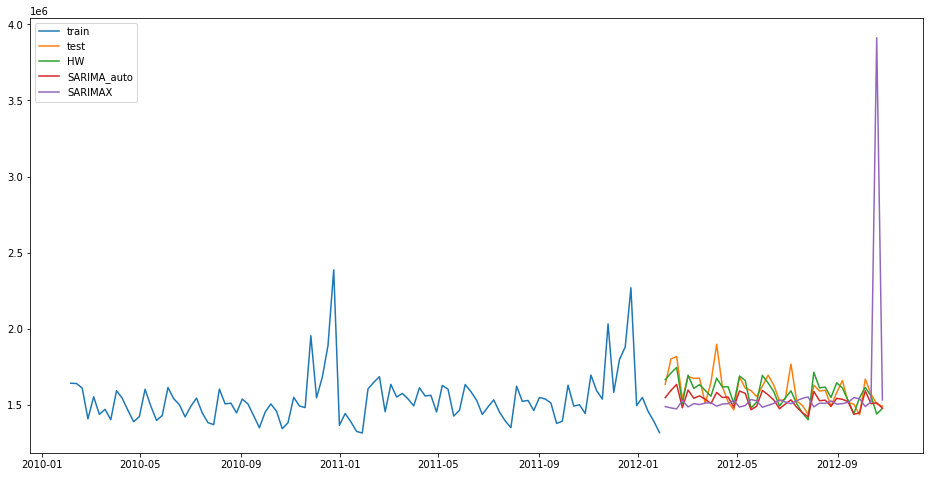

In [48]:
plt.figure(figsize=(16,8))
plt.plot(train['sales'], label='train')
plt.plot(test['sales'], label='test')
plt.plot(df_predictions['hw'], label='HW')
plt.plot(df_predictions['sarima_auto'], label='SARIMA_auto')
plt.plot(df_predictions['sarimax'], label='SARIMAX')
plt.legend();

#### Score

In [49]:
mean_squared_error(test['sales'], preds, squared=False)

412795.89013405214

The AIC penalizes more features (in this sense, it's like adjusted R2).  

If you have a model that isn't predicting well, you could try to manually make the time series stationary by doing things like Power Transforming it prior to fitting. 

---
## Summary

You've seen how to fit SARIMA and SARIMAX models with `pmd.auto_arima`.

ARIMA models and ETS models (The Exponential Smoothing family including Holt Witners) share some overlap. See [Hyndman](https://otexts.com/fpp3/arima-ets.html) for discussion.

These two model families are quite good for univariate forecasting. SARIMAX lets you add other features to your model.

### Check for understanding

- What do pdq and PDQ stand for?
- How do you add more features to a SARIMA model?